# Using TabNet to predict Suicidality

We want to predict suicidal ideation and attempts of the children through the deep learning model TabNet which is suit for tabular data.

The TabNet training model works in four steps:
1. Preprocessing the data
2. Finding the hyperparameter which make the best auc performance (= hyperparameter-tuning)
3. Training the TabNet model
4. Extract important features




# Get ready to work!



## Import libraries and load dataset
Import libraries we need and load the dataset we use

1. import labraries

In [ ]:
!pip install pytorch_tabnet

In [ ]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
"""using stratified k fold instead of k fold"""
from sklearn.model_selection import StratifiedKFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
from pathlib import Path
import os
from sklearn.metrics import confusion_matrix

2. load data


*   Load resting psychosocial, state fMRI, structural MRI, and diffusion MRI
*   Create index arrays whose values are the positions(=index) of the features in column

> The shape of the total data's subject is (5827, 5019).
> 
> Train data has 5019 features of the 5510 subjects.
> 
> Test data has 5019 features of the 317 subjects.

In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
# psychosocial + rsfMRI + strurctural MRI + diffusion MRI
dataset_name = 'rsf(corr)_s_dMRI'

#train_out = Path(os.getcwd()+'/sample_data/si_ppc_'+dataset_name+'_train.csv')
#test_out =Path(os.getcwd()+'/sample_data/si_ppc_'+dataset_name+'_test.csv')
train_out = '/content/sample_data/si_ppc_'+dataset_name+'_train.csv'
test_out = '/content/sample_data/si_ppc_'+dataset_name+'_test.csv'

# change form of the data file to csv
train_data= pd.read_csv(train_out)
test_data= pd.read_csv(test_out)

# Set target (class) and not using features
target ='Suicidalideation'
unused_feat = ['abcd_site','kfold']

In [ ]:
# get the start column index of each feature
start_psycho_index = np.where(test_data.columns.values == "race.ethnicity_1")[0][0]
start_rsfmri_index = np.where(test_data.columns.values == "rsfmri_cor_network.gordon_auditory_network.gordon_auditory")[0][0]
start_structmri_index = np.where(test_data.columns.values == "lh_bankssts_area._.1")[0][0]
start_diffmri_index = np.where(test_data.columns.values == "con_L.BSTS_L.CACG_count")[0][0]

psychosocial = list(test_data.columns[start_psycho_index:start_rsfmri_index])
rsf_mri = list(test_data.columns[start_rsfmri_index:start_structmri_index])
structural_mri = list(test_data.columns[start_structmri_index:start_diffmri_index])
diffusion_mri = list(test_data.columns[start_diffmri_index:])

Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 20

print(len(train_data), len(train_data.columns))
print(len(test_data), len(test_data.columns))
print(len(psychosocial))
print(len(rsf_mri))
print(len(structural_mri))
print(len(diffusion_mri))

2326 5019
317 5019
129
416
984
3485


## Define preprocessing function for Cross-validation



*   Divide all the subjects into sub-group by folds.

*   In n-th fold, then we use n-th fold dataset as test(validation) data among k datasets.






In [ ]:
def preprocessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1
    train_data_processed["kfold"] = -1

    # reordering the data
    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)
    
    """change k fold to stratified k fold"""
    # kf = KFold(n_splits=NUM_FOLDS) 
    kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state =0)
    
    # Split the dataset into train(80%), validation(20%)
    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed[target])):
        # 'kfold' column : the fold order in cross validation
        train_data_processed.loc[val_, 'kfold'] = fold
    
    print("done preprocessing")
    return train_data_processed, test_data_processed

In [ ]:
train_data_processed, test_data_processed = preprocessing (train_data, test_data, Num_FOLDS)

done preprocessing


In [ ]:
train_data_processed.head(10)

,Unnamed: 0,X,subjectkey,abcd_site,Suicidalideation,race.ethnicity_1,race.ethnicity_2,race.ethnicity_3,race.ethnicity_4,race.ethnicity_5,sex_1,sex_2,high.educ_1,high.educ_2,high.educ_3,high.educ_4,high.educ_5,high.educ_6,high.educ_7,high.educ_8,high.educ_9,high.educ_10,high.educ_11,high.educ_12,high.educ_13,high.educ_14,high.educ_15,high.educ_16,high.educ_17,high.educ_18,high.educ_19,income_1,income_2,income_3,income_4,income_5,income_6,income_7,income_8,income_9,...,con_R.RMFG_R.TTG_count,con_R.RMFG_R.IN_count,con_R.RMFG_R.CER_count,con_R.SFG_R.SPG_count,con_R.SFG_R.STG_count,con_R.SFG_R.SMG_count,con_R.SFG_R.FP_count,con_R.SFG_R.TP_count,con_R.SFG_R.TTG_count,con_R.SFG_R.IN_count,con_R.SFG_R.CER_count,con_R.SPG_R.STG_count,con_R.SPG_R.SMG_count,con_R.SPG_R.FP_count,con_R.SPG_R.TP_count,con_R.SPG_R.TTG_count,con_R.SPG_R.IN_count,con_R.SPG_R.CER_count,con_R.STG_R.SMG_count,con_R.STG_R.FP_count,con_R.STG_R.TP_count,con_R.STG_R.TTG_count,con_R.STG_R.IN_count,con_R.STG_R.CER_count,con_R.SMG_R.FP_count,con_R.SMG_R.TP_count,con_R.SMG_R.TTG_count,con_R.SMG_R.IN_count,con_R.SMG_R.CER_count,con_R.FP_R.TP_count,con_R.FP_R.TTG_count,con_R.FP_R.IN_count,con_R.FP_R.CER_count,con_R.TP_R.TTG_count,con_R.TP_R.IN_count,con_R.TP_R.CER_count,con_R.TTG_R.IN_count,con_R.TTG_R.CER_count,con_R.IN_R.CER_count,kfold
0,1799,1799,NDARINVA1A1R65H,7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,-0.716253,-0.468683,-0.333610,0.996137,0.014790,0.465232,0.672203,0.103277,-0.536019,-0.592324,-0.100393,2.200748,-0.136701,1.607978,-0.368455,1.089732,0.462392,-0.927877,0.883990,0.331896,-0.769956,2.122436,-1.434421,-0.287827,-0.361203,0.889571,0.052236,-0.265021,-0.543032,-0.261251,-0.106171,0.968776,-0.13702,-0.189721,-0.503834,-0.274884,0.991228,-0.474512,0.572809,4
1,876,876,NDARINV4X6J651P,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,-0.041528,-0.658974,-0.139992,0.823889,0.100951,-0.192566,0.705836,1.767457,-0.768309,-1.114687,-0.670959,1.042577,0.402447,-0.323452,-0.131015,0.106278,-0.716357,0.018715,1.137880,-0.365029,0.324429,0.475110,-0.421332,-0.287827,-0.361203,-0.399832,0.677507,0.347327,0.216824,-0.261251,-0.106171,0.165055,-0.13702,-0.189721,0.536635,-0.274884,-0.990834,0.830664,-0.778556,2
2,783,783,NDARINV4BU3CBM5,21,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.183381,-0.986451,-0.527228,0.260770,1.651840,0.824031,0.255155,0.103277,1.554597,-0.011921,-0.528317,0.468051,-0.859858,-0.323452,-0.131015,-0.494721,-1.585831,-0.888436,0.134889,-0.365029,-0.378139,-0.195657,1.163577,0.176657,-0.361203,-0.399832,-0.225663,-1.203170,-0.868684,-0.261251,-0.106171,-0.192154,-0.13702,-0.189721,0.990738,-0.274884,-0.226914,0.830664,-0.665942,2
3,1425,1425,NDARINV83TT3MW4,16,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,-0.266436,-1.382521,-0.527228,2.334372,-0.674494,-0.162666,-0.108081,1.767457,-0.071438,0.088330,0.755456,-0.170310,0.277320,-0.323452,0.581304,1.435761,-0.407082,4.081169,-0.445791,-0.365029,-0.222763,-0.306136,-0.891322,0.176657,-0.361203,0.889571,1.747417,0.563219,3.690452,-0.261251,-0.106171,-0.549363,-0.13702,3.344864,1.630009,2.564233,-0.732753,-0.474512,1.924174,3
4,442,442,NDARINV2BW6G83G,8,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.041528,1.350143,0.440861,1.784503,-0.329852,-0.132766,-0.565488,-0.451449,-0.768309,0.805920,-0.480770,0.759874,1.177127,-0.323452,0.106424,-0.130479,1.728673,-0.888436,1.638119,-0.365029,0.999976,4.085416,0.722309,-0.752311,-0.361203,2.178974,1.302779,2.192223,-0.760133,-0.261251,-0.106171,0.432962,-0.13702,-0.189721,3.190712,-0.274884,-0.877278,-0.474512,4.739517,4
5,1653,1653,NDARINV97EZB853,10,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,-0.266436,0.653147,2.957891,0.982887,0.014790,1.392130,0.409866,0.103277,-0.536019,1.684439,1.468663,0.705157,0.356444,-0.323452,0.343864,0.215551,0.911718,-0.888436,1.969935,-0.36

# Dataset is ready! Let's define some important functions we need.

We need to tune the hyperparameter when we train our model TabNet. We test some combinations of the hyperparameter and find the set of hyperparameters that gets the highest AUC performance.

We want to extract important featuers, so we have to calculate the importance of the features.

## Define feature importance function to get the importance of the features

In [ ]:
def feature(Num_feat, clf_res, test_data_processed, features):
    importance_res = []
    # Save and stack the k importances of the feautures in an array
    for i in clf_res:
        importance_clf =i.feature_importances_
        importance_res.append(importance_clf)
    
    # Calculate the average of importance values ​​of features from each of k folds
    importance=[importance_res[0][i]/5+importance_res[1][i]/5+ importance_res[2][i]/5+ importance_res[3][i]/5+ importance_res[4][i]/5 for i in range(len(importance_res[1]))]

    feat_name_sort = test_data_processed[features].columns
    important_features = pd.DataFrame([importance],columns = feat_name_sort, index=['Importance']) 
    important_features =important_features.transpose().sort_values(by=['Importance'], ascending=False)
    important_features = important_features.head(Num_feat)

    return important_features

## Define parameter-tuning function to find best hyperparameter

In [ ]:
def find_bestpar(fold, train_data_processed, test_data_processed, features):
    
    """Make test data"""
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values
    
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []

    """
    # define hyperparameter space (original version)
    n_ = [4,8,16]                              # 
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4] # learning rate
    w_ = [0.01, 0.001, 0.0001]                 # weight decay
    g_ = [0.95, 0.99, 0.9]                     # scheduler params - gamma
    ss_ = [10, 20, 30]                         # scheduler params - step_size
    """
    # define hyperparameter space (quick version)
    n_ = [4,16]
    lr_ = [2e-2,1e-3]
    w_ = [0.01,0.001]
    g_ = [0.95,0.99]
    ss_ = [10,30]
    
    
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    # hyperparameter tuning
    for hy in tqdm(h_space):
        
        """define arrays to save the results of the validation & test"""
        valid_res = []
        test_auc_res = []
        test_acc_res = []
     
        # cross-validation
        for i in range(fold):
            # define the model
            clf = TabNetClassifier(n_a = hy[0],
                                n_d = hy[0],
                                optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                                scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                verbose=0)
            
            df_train = train_data_processed[train_data_processed.kfold != i]  # train : 4/5
            df_valid = train_data_processed[train_data_processed.kfold == i]  # validation : 1/5
            
            X_train = df_train[features].values
            Y_train = df_train[target].values
            
            X_valid = df_valid[features].values
            Y_valid = df_valid[target].values
            
            # train the model with our train dataset
            clf.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                    eval_name=['train', 'valid'], eval_metric=['auc'],
                    max_epochs=200 , patience=20)
       
            # test the model which is trained above
            preds_acc = clf.predict(X_test)
            preds_prob = clf.predict_proba(X_test)
            test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
            test_acc = accuracy_score(preds_acc, Y_test)
            
            valid_res.append(clf.best_cost)
            test_auc_res.append(test_auc)
            test_acc_res.append(test_acc)
            print('[%3d/%4d] '%(i+1, fold),'Valid score: %2f'% clf.best_cost, 'Test AUC: %.3f%%'%test_auc, 'Test ACC: %.3f%%'%test_acc)
    
        """print average and standard deviation of validation and testing"""
        print("=====parameter valid, test score=====")
        print("Validation average: %3f"%np.mean(valid_res), "Test AUC average: %3f"%np.mean(test_auc_res), "Test ACC average: %3f"%np.mean(test_acc_res))

        # save best AUC performance and the hyperparameter set that make the best AUC score
        if np.mean(test_auc_res)>max_auc:
            print("Find new maximum AUC!!")
            max_hy = hy
            max_auc = np.mean(test_auc_res)
    
    return max_hy

## Define Training function with best parameter

In [ ]:
def bestpar_tuning(fold, train_data_processed, test_data_processed, max_hy, features):
    # bring the hyperparameter set making the best performance
    hy = max_hy
    print("Max hy:" ,hy)

    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    """define arrays saving the results of validation & test"""
    valid_res = []
    test_auc_res = []
    test_acc_res = []
    clf_res = []
    preds_prob_res = []
     
    y_valid_true = []
    y_valid_pred = []
    y_test_pred = []
    
    y_valid_subject = []
    y_test_subject = []
    
    
    for i in range(fold):
        clf = TabNetClassifier(n_a = hy[0],n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0)
        
        df_train = train_data_processed[train_data_processed.kfold != i]  # using the data of 4 folds dataset as training dataset
        df_valid = train_data_processed[train_data_processed.kfold == i]  # using the data of 1 fold dataset as validation dataset
            
        X_train = df_train[features].values
        Y_train = df_train[target].values
            
        X_valid = df_valid[features].values
        Y_valid = df_valid[target].values
        
        # bring subject key before the training
        y_valid_subject.append(df_valid['subjectkey'].values)
        y_test_subject.append(test_data_processed['subjectkey'].values)  
        y_valid_true.append(Y_valid)        
        
        # Training
        clf.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                        eval_name=['train', 'valid'], eval_metric=['auc'],
                        max_epochs=200 , patience=20)
        
        # Results
        preds_prob_val= clf.predict_proba(X_valid)[:,1]
        y_valid_pred.append(preds_prob_val)
        y_test_pred.append(clf.predict(X_test))

        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
                    
        valid_res.append(clf.best_cost)
        test_auc_res.append(test_auc)
        test_acc_res.append(test_acc)
        preds_prob_res.append(preds_prob)
        clf_res.append(clf)

        print('[%3d/%4d] '%(i+1, fold),'Valid score: %2f'% clf.best_cost, 'Test AUC: %.3f'%test_auc, 'Test ACC: %.3f'%test_acc)

    """print average and standard deviation of validation and testing"""
    print("Validation average: %3f"%np.mean(valid_res), "Test AUC average: %3f "%np.mean(test_auc_res), "Test ACC average: %3f"%np.mean(test_acc_res))
    
    preds_prob=[preds_prob_res[0][i]/5+preds_prob_res[1][i]/5+ preds_prob_res[2][i]/5+ preds_prob_res[3][i]/5+ preds_prob_res[4][i]/5 for i in range(len(preds_prob_res[1]))]
    preds_prob = np.array(preds_prob)
    valid_result = np.mean(valid_res)
    test_auc = np.mean(test_auc_res)
    test_acc = np.mean(test_acc_res) 
    
    #return test_auc,test_acc ,valid_result, clf_res, preds_prob, X_test, Y_test, y_valid_pred, y_test_pred, y_valid_subject, y_test_subject
    return test_auc,test_acc ,valid_result, clf_res, preds_prob, X_test, Y_test, y_valid_pred, y_test_pred, y_valid_subject, y_test_subject, y_valid_true


## Define run function


*   Call the functions defined above.
*   Get and return the results including test AUC, ACC score.




In [ ]:
def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    name_test = test_data_processed['subjectkey'].values
    
    # Finding best performance hyperparameter (Hyperparameter tuning)
    max_hy = find_bestpar(fold, train_data_processed, test_data_processed, features)
    
    # Training with best hyperparameter
    test_auc,test_acc ,valid_result, clf_res, preds_prob, X_test, Y_test, y_valid_pred, y_test_pred, y_valid_subject, y_test_subject, y_valid_true= bestpar_tuning(fold, 
                                                                                        train_data_processed, 
                                                                                        test_data_processed, 
                                                                                        max_hy, 
                                                                                        features)
    
    # Calculating the importances of the features and extracting 50 important features
    import_feat=feature(Num_feat, clf_res, test_data_processed, features)
    
    return test_auc,test_acc ,valid_result, clf_res, preds_prob, X_test, Y_test, import_feat, name_test, y_valid_pred, y_test_pred, y_valid_subject, y_test_subject, y_valid_true


## Define function saving the results as csv file

This is used for stacking ensemble model.

In [ ]:
def save_prob_with_true(model):
    modeltype= "" 
    combined_model=pd.DataFrame({f"subjectkey": model.y_test_subject[0], f"Y_{modeltype}":model.Y_test, f"preds_prob_{modeltype}" :model.preds_prob[:,1]} )
    combined_model.to_csv(f"combined_forROC_{modeltype}_.csv")

    return combined_model

def save_prob_with_true_valid(model):
    modeltype= "" 
    
    combined_model=pd.DataFrame({f"subjectkey": list(itertools.chain(*model.y_valid_subject)), f"Y_{modeltype}":list(itertools.chain(*model.y_valid_true)), f"preds_prob_{modeltype}" :list(itertools.chain(*model.y_valid_pred) )})
    combined_model.to_csv(f"combined_forROC_{modeltype}_.csv")

    return combined_model

## Define main function

Call the run function with our preprocessed train & test dataset.

Save the results returned for confirm the results.

In [ ]:
class model():
    def __init__(self, train_data_processed, test_data_processed, Num_FOLDS, Num_feat, features):
        test_auc,test_acc ,valid_result, clf_res, preds_prob, X_test, Y_test, import_feat, name_test, y_valid_pred, y_test_pred, y_valid_subject, y_test_subject, y_valid_true = run(train_data_processed,
                                                                              test_data_processed,
                                                                              Num_FOLDS, 
                                                                              Num_feat, 
                                                                              features)
    
    
        self.train_data_processed = train_data_processed
        self.test_auc = test_auc
        self.test_acc = test_acc
        self.valid_result = valid_result
        self.clf_res = clf_res 
        self.preds_prob = preds_prob 
        self.X_test = X_test
        self.Y_test = Y_test
        self.import_feat =  import_feat
        self.name_test = name_test
        self.features = features
        self.y_valid_pred =y_valid_pred
        self.y_test_pred = y_test_pred
        self.y_valid_subject= y_valid_subject
        self.y_test_subject = y_test_subject
        self.y_valid_true = y_valid_true

        test_prob_result = save_prob_with_true(self)
        valid_prob_result = save_prob_with_true_valid(self)
        self.test_prob_result= test_prob_result
        self.valid_prob_result = valid_prob_result        

# All dataset and functions are ready! Let's train our model. 

In [ ]:
# Select the features we want to use
features = [col for col in train_data_processed.columns if col in psychosocial + rsf_mri + structural_mri + diffusion_mri]

# Call the model function to tune the hyperparameter and train the TabNet model
rsf_s_d_model = model(train_data_processed, test_data_processed, Num_FOLDS, Num_feat, features)

# We are done! Let's get the results

In [ ]:
print(rsf_s_d_model.valid_result)
print(rsf_s_d_model.test_auc)

0.7492064576989276
0.6568505692221958


In [ ]:
rsf_s_d_model.import_feat

,Importance
Internal.and.External.Comobidity,0.166500
Depress.CBCL,0.042368
WithDep.CBCL,0.031361
fes_q1_1,0.029827
rh_lateralorbitofrontal_thickness._.6,0.029299
External.CBCL,0.022822
rh_G.S_frontomargin_area._.14,0.020294
AnxDep.CBCL,0.019561
rh_S_parieto_occipital_volume._.17,0.017230
rsfmri_cor_network.gordon_auditory_subcort.aseg_accumbens.area.rh,0.013686


## Draw ROC curve graph
1. Define the function drawing the roc curve

In [ ]:
def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )

2. Draw the roc curve of our model

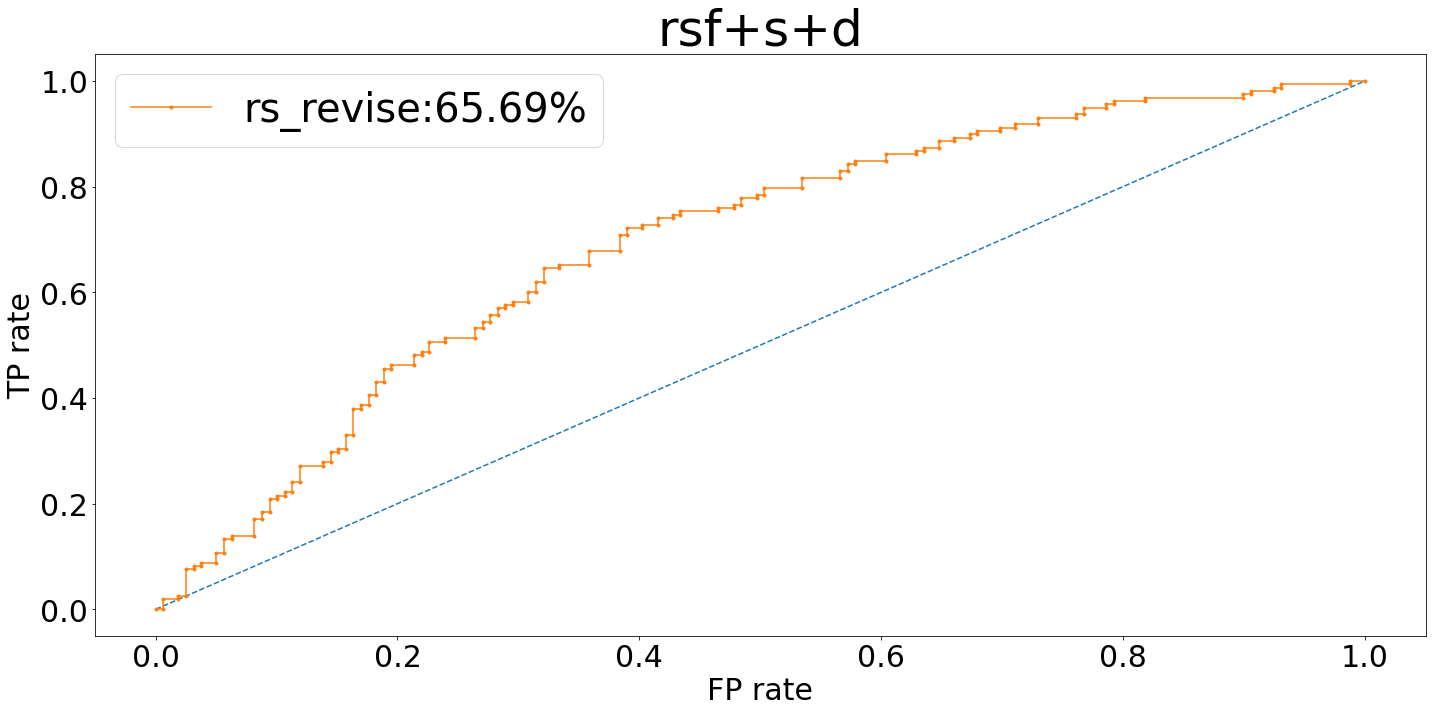

In [ ]:
fig , ax = plt.subplots(figsize= (20,10))
plt.plot([0, 1], [0, 1], linestyle='--')
rocvis(rsf_s_d_model.Y_test , rsf_s_d_model.preds_prob[:,1] , f"rs_revise:{round(rsf_s_d_model.test_auc*100, 2)}%")


dataset_name="rsf+s+d"

plt.legend(fontsize = 40)
plt.title(dataset_name, fontsize= 50)
plt.xlabel("FP rate", fontsize =30)
plt.ylabel("TP rate", fontsize =30)
plt.xticks(size = 30)
plt.yticks(size = 30)

plt.tight_layout()
plt.savefig(f'{dataset_name}_ROC.png')